#### Notes before Running

- This script assumes you have already run download-bands.py script and a project directory has been created 
- Place the field shapefile send into the project directory (gt-task\). This field is the first downloaded field from download-bands.py script and was used to test.
- Set the project directory and field_id before running
- Select Harvest Assumption before running (True or False)/ default == Assunption3

#### Imports

In [1]:
import os
import rasterio
from rasterio import plot
from rasterio.mask import mask
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import fiona

## !! Set !!

##### Set projectdir and field_id 

In [2]:
field_id = '1f5db323-de26-11eb-96a1-5b57f233df61'
projectdir = r'C:\Users\csoti\Desktop\notebooks\GreenTriangle2\gt-task'

##### Select Harvest Assumption 

In [3]:
## Assumption1: 
# Harvest events confirm when, a high NDVI observation, >0.3, 
# is followed by two low NDVI observations, <0.1 
Assumption1 = False

## Assumption2: 
# Harvest events confirm when, two high NDVI observations, >0.3, 
# are followed by two low NDVI observations, <0.1 
Assumption2 = False

# Assumption3: 
# Harvest events confirm when, three high NDVI observations, >0.3, 
# are followed by three low NDVI observations, <0.1 
Assumption3 = True

### Preprocessing

In [4]:
fid = field_id.replace("-", "")
field_shp = os.path.join(projectdir, fid + '.shp')
assert os.path.exists(field_shp)

tiles = os.path.join(projectdir, 'tiles', field_id)
assert os.path.exists(tiles)

ndvidir = os.path.join(projectdir, 'ndvi', os.path.basename(tiles))
if not os.path.exists(ndvidir):
    os.makedirs(ndvidir)

clipdir = os.path.join(projectdir, 'clip', os.path.basename(tiles))
if not os.path.exists(clipdir):
    os.makedirs(clipdir)

noDatadir =  os.path.join(projectdir, 'nodata', os.path.basename(tiles))
if not os.path.exists(noDatadir):
    os.makedirs(noDatadir)

stackdir = os.path.join(projectdir, 'stack', os.path.basename(tiles))
if not os.path.exists(stackdir):
    os.makedirs(stackdir)


### Functions

In [5]:
def compute_ndvi(tiles, ndvidir):
    for folder in os.listdir(tiles):
        folderpath = os.path.join(tiles, folder)
        subDir = os.listdir(folderpath)
        if "B04.tiff" in subDir[1]:
            date = datetime.datetime.strptime(folder, '%Y-%m-%d').strftime('%Y%m%d')
            band4 = rasterio.open(os.path.join(folderpath ,subDir[1]))
            band8 = rasterio.open(os.path.join(folderpath ,subDir[2]))
    
            red = band4.read().astype('float32')
            nir = band8.read().astype('float32')
            ndvi=np.where((nir+red)==0., 0, (nir-red)/(nir+red))
    
            b4meta  = rasterio.open(os.path.join(folderpath ,subDir[1]))
            ndviout = os.path.join(ndvidir , date + '_ndvi.tif')
            if not os.path.exists(ndviout):
                ndviTiff = rasterio.open(ndviout,'w',driver='Gtiff',
                                  width = b4meta.width, 
                                  height = b4meta.height, 
                                  count=1, crs=b4meta.crs, 
                                  transform=b4meta.transform, 
                                  dtype='float64')
                ndviTiff.write(ndvi)
                ndviTiff.close()

def clip_rasters(fpath, fshp, outdir): 

    bandNames = os.listdir(fpath)
    shp = fiona.open(fshp)
    aoiGeom = [shp[0]['geometry']]
    
    #clip all rasters
    for band in bandNames:
        rasterPath = os.path.join(fpath,band)
        rasterBand = rasterio.open(rasterPath)
        outImage, outTransform = mask(rasterBand, aoiGeom, crop=True, filled=True, all_touched=False )
        outMeta = rasterBand.meta
        outMeta.update({"driver": 'GTiff',
                     "height": outImage.shape[1],
                     "width": outImage.shape[2],
                     "transform": outTransform})
        outPath = os.path.join(outdir,band)
        if not os.path.exists(outPath):
            outRaster = rasterio.open(outPath, "w", **outMeta) 
            outRaster.write(outImage)
            outRaster.close()

def fix_no_data_value(input_file, output_file, no_data_value=0):
    with rasterio.open(input_file, "r+") as src:
        src.nodata = no_data_value
        with rasterio.open(output_file, 'w',  **src.profile) as dst:
            for i in range(1, src.count + 1):
                band = src.read(i)
                band = np.where(band==no_data_value,no_data_value,band)
                dst.write(band,i)
                
        
def stack_rasters(rasterdir, stackdir):
    raster_list = []
    for file in os.listdir(rasterdir):
        filepath = os.path.join(rasterdir, file)
        raster_list.append(filepath)
    
    # Read metadata of first file
    with rasterio.open(raster_list[0]) as src0:
        meta = src0.meta
    
    # Update meta to reflect the number of layers
    meta.update(count = len(raster_list))
    
    # Read each layer and write it to stack
    year = raster_list[0].split('_')[0][-8:-4]
    stackout = os.path.join(stackdir , year + '_stack.tif')
    if not os.path.exists(stackout):
        with rasterio.open(stackout, 'w', **meta) as dst:
            for id, layer in enumerate(raster_list, start=1):
                with rasterio.open(layer) as src1:
                    dst.write_band(id, src1.read(1))



### Run

##### Compute NDVI

In [22]:
compute_ndvi(tiles, ndvidir)

##### Clip Rasters

In [23]:
clip_rasters(ndvidir, field_shp, clipdir)

##### Fix No data

In [24]:
for file in os.listdir(clipdir):
    input_file = os.path.join(clipdir, file)
    out_file = os.path.join(noDatadir, file)
    if not os.path.exists(out_file):
        fix_no_data_value(input_file, out_file, no_data_value=0)

##### Stack rasters

In [9]:
stack_rasters(noDatadir, stackdir)

##### Get Mean NDVI values

In [6]:
dates_list = []
ndvi_mean_list = []

bandNames = os.listdir(noDatadir)

for img in bandNames:
    img_path = os.path.join(noDatadir, img)
    img_open = rasterio.open(img_path)
    img_read = img_open.read()
    mean_value = img_read.mean()
    # median_value = np.median(img_read)
    if mean_value<0:
        mean_value=0
    ndvi_mean_list.append(mean_value)
    date = img.split('_')[0]
    dates_list.append(date)

##### Compute Biomass from Mean NDVI List

In [7]:
biomass_list = []
for ndvi_m in ndvi_mean_list:
    if ndvi_m>0.2:
        biomass = ((8.957*102)*ndvi_m - (2.854*102))/1000
    else:
        biomass = 0
    biomass_list.append(biomass)

##### Create Dataframe

In [8]:
df = pd.DataFrame({'Dates': dates_list,
                   'NDVI_mean': ndvi_mean_list})

#convert date column to datetime format
df['Dates'] = pd.to_datetime(df['Dates'])
df['biomass'] = biomass_list
df

,Dates,NDVI_mean,biomass
0,2021-02-11,0.038795,0.000000
1,2021-02-21,0.293483,-0.022978
2,2021-03-28,0.367721,0.044847
3,2021-04-02,0.424793,0.096989
4,2021-04-27,0.470034,0.138322
5,2021-06-01,0.511356,0.176074
6,2021-06-16,0.500328,0.165999
7,2021-07-21,0.175412,0.000000
8,2021-08-25,0.111693,0.000000
9,2021-09-24,0.126494,0.000000


##### Get Yield

In [26]:
before_harvest_list = []
biomass_per_harvest = []
harvest_date = []
harvest_event = []

if Assumption1 == True:
    for prev, curr, next in zip(ndvi_mean_list, ndvi_mean_list[1:], ndvi_mean_list[2:]):
        if prev>0.3 and curr<0.1 and next<0.1:
            before_harvest_list.append(prev)
            for i, j in df.iterrows():
                if j[1]==prev:
                    biomass_per_harvest.append(j[2])
           # print(prev, curr, next)

elif Assumption2 == True:
    for prev2, prev1, curr, next in zip(ndvi_mean_list, ndvi_mean_list[1:], ndvi_mean_list[2:], ndvi_mean_list[3:]):
        if prev2>0.3 and prev1>0.3 and curr<0.1 and next<0.1:
            before_harvest_list.append(prev1)
            for i, j in df.iterrows():
                if j[1]==prev1:
                    biomass_per_harvest.append(j[2])
                
            #print(prev2, prev1, curr, next)

elif Assumption3 == True:
    for prev3, prev2, prev1, curr, next, next1 in zip(ndvi_mean_list, ndvi_mean_list[1:], ndvi_mean_list[2:], ndvi_mean_list[3:],ndvi_mean_list[4:], ndvi_mean_list[4:]):
        if prev3>0.3 and prev2>0.3 and prev1>0.3 and curr<0.2 and next<0.2 and next1<0.2:
            before_harvest_list.append(prev1)
            for i, j in df.iterrows():
                if j[1]==prev1:
                    biomass_per_harvest.append(j[2])
                    harvest_date = j[0].strftime('%Y%m%d')
                
                if j[1]==curr:
                    harvest_event = j[0].strftime('%Y%m%d')                   
                
            #print(prev2, prev1, curr, next)

In [27]:
print(len(biomass_per_harvest), 'times for',  round((sum(biomass_per_harvest)),2), 't/ha')

1 times for 0.17 t/ha


In [28]:
harvest_date, harvest_event

('20210616', '20210721')

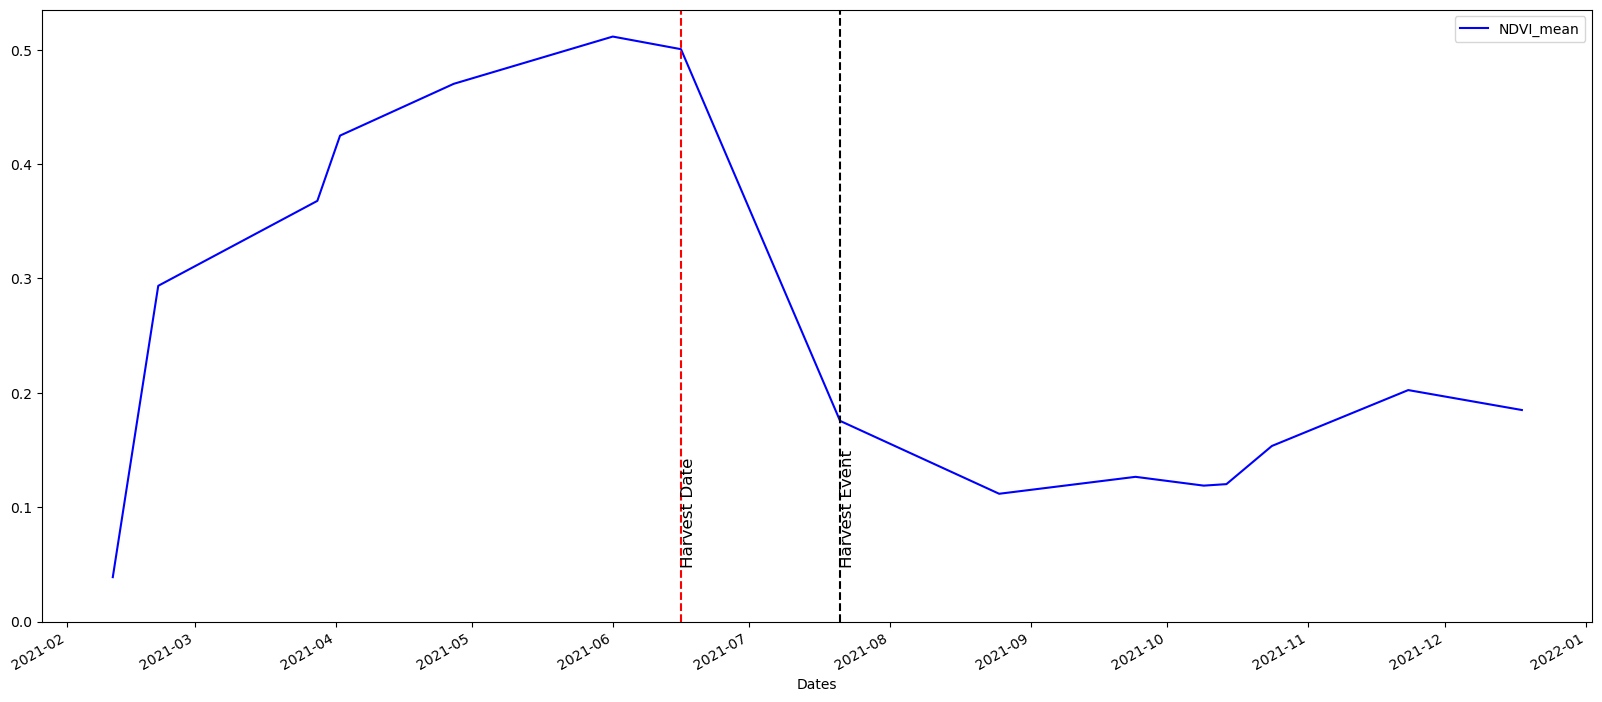

In [35]:
fig, ax = plt.subplots(figsize=(20,9))
df.plot.line(x='Dates', y='NDVI_mean', color='blue', ax=ax)
ax.set_ylim(bottom=0)
ax.axvline(x=harvest_date, color='r', ls='--')
plt.text(harvest_date, 0.05, 'Harvest Date', fontsize=12, rotation=90)
ax.axvline(x=harvest_event, color='k', ls='--')
plt.text(harvest_event, 0.05, 'Harvest Event', fontsize=12, rotation=90)
plt.show()